## Reinforced Concrete 3D Frame
#### January 2022, By Amir Hossein Namadchi
In this notebook, a 3-Dimensional one story Reinforced Concrete moment resisting frame is modeled. This is an OpenSeesPy simulation of TCL version of the model, presented by [*Fernando Gutiérrez Urzúa*](https://www.ucl.ac.uk/epicentre/fernando-gutierrez-urzua) in his [YouTube channel](https://www.youtube.com/user/lfgurzua). Some minor modifications are made by me in the python version. According to his, modeling assumptions are:

- Columns & Beams are modeled as distributed plasticity elements

To have cleaner code, all of the neccessary functions are written in a single *.py* file named `RC3DF.py`. The file contains:
- `build_RC_rect_section`: *Build fiber rectangular RC section*
- `build_model`: *Builds the 3D RC Frame model*
- `run_gravity`: *Runs gravity analysis*
- `run_modal`: *Runs Modal analysis*
- `run_pushover`: *Runs Pushover analysis*
- `run_time_history`: *Runs Time history analysis*
- `reset_analysis`: *Resets the analysis by setting time to 0,removing the recorders and wiping the analysis.*

Some additional function arguments are provided to be able to tweak model parameters. Please note that some functions use data obtained by running other functions. For example, in order to run time-history analysis, some of the system's natural frequencies are required which can be obtained by running `run_modal` function.

The model has been idealized as follows:

![RC Frame](FGU_RC3DF_files/RCFrameIdealization.PNG)

Beam and Column sections are defined as:

![RC Frame Sections](FGU_RC3DF_files/RCFrameSections.PNG)

### Dependencies

In [1]:
import time
import sys
import os
sys.path.append('FGU_RC3DF_files')
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import RC3DF as RC

### Model Data

#### Units (*Silvia's Style*)

In [2]:
m = 1.0               # Meters
KN = 1.0              # KiloNewtons
sec = 1.0             # Seconds

mm = 0.001*m          # Milimeters
cm = 0.01*m           # Centimeters 
ton = KN*(sec**2)/m   # mass unit (derived)
g = 9.81*(m/sec**2)   # gravitational constant (derived) 
MPa = 1e3*(KN/m**2)   # Mega Pascal 
GPa = 1e6*(KN/m**2)   # Giga Pascal 

#### Geometric Dimensions

In [3]:
L_X = 6.0*m          # Span in X-direction
L_Y = 7.0*m          # Span in Y-direction
L_Z = 3.5*m          # Story height

#### Material Definition

In [4]:
f_c_1 = -25*MPa          # f'c in compression for unconfined concrete
f_c_2 = -28*MPa          # f'c in compression for confined concrete
eps_c = -0.002           # strain at maximum stress in compression 
eps_u = -0.02            # strain at ultimate stress in compression
f_y = 420.0*MPa          # fy for reinforcing steel
E_s = 210.0*GPa          # E for reinforcing steel

#### Section Definition

In [5]:
rebar = 0.25*np.pi*(25*mm)**2

# uniaxial Kent-Scott-Park concrete material with degraded linear unloading/reloading
mat_KSP_unconf = {'ID':'Concrete02',
                  'matTag': 1,
                  'fpc': f_c_1,
                  'epsc0': eps_c,
                  'fpcu': 0.2*f_c_1,
                  'epsU': eps_u,
                  'lamda': 0.1,
                  'ft': -0.1*f_c_1,
                  'Ets': (-0.1*f_c_1)/0.002}
# uniaxial Kent-Scott-Park concrete material with degraded linear unloading/reloading
mat_KSP_conf = {'ID':'Concrete02',
                  'matTag': 2,
                  'fpc': f_c_2,
                  'epsc0': eps_c,
                  'fpcu': 0.2*f_c_2,
                  'epsU': eps_u,
                  'lamda': 0.1,
                  'ft': -0.1*f_c_2,
                  'Ets': (-0.1*f_c_2)/0.002}

# uniaxial Giuffre-Menegotto-Pinto steel with isotropic strain hardening
mat_GMP = {'ID':'Steel02',
           'matTag':3,
           'Fy': f_y,
           'E0': E_s,
           'b':0.005,
           'R0': 20.0,
           'cR1': 0.925,
           'cR2': 0.15}


sections = {'Beam':{'B':300*mm,
                        'H':600*mm,
                        'cover':40*mm,
                        'n_bars_top':3,
                        'n_bars_bot':3,
                        'n_bars_int_tot':4,
                        'bar_area_top':rebar,
                        'bar_area_bot':rebar,
                        'bar_area_int':rebar},

            'Column':{'B':300*mm,
                        'H':400*mm,
                        'cover':40*mm,
                        'n_bars_top':3,
                        'n_bars_bot':3,
                        'n_bars_int_tot':4,
                        'bar_area_top':rebar,
                        'bar_area_bot':rebar,
                        'bar_area_int':rebar}
           }   

#### Loading

In [6]:
C_L = 80.0*(KN)      # Concentrated load
m_1 = 200.0*ton       # lumped mass 1

### Analysis

#### Gravity analysis

In [7]:
RC.build_model(L_X, L_Y, L_Z, mat_KSP_unconf, mat_KSP_conf, mat_GMP, sections, C_L, m_1)
RC.run_gravity()

Model Built Successfully!
Gravity analysis Done!


#### Modal analysis

In [8]:
RC.build_model(L_X, L_Y, L_Z, mat_KSP_unconf, mat_KSP_conf, mat_GMP, sections, C_L, m_1)
RC.run_modal()

Model Built Successfully!
Modal analysis Done!


#### Pushover analysis in X directions

In [9]:
RC.build_model(L_X, L_Y, L_Z, mat_KSP_unconf, mat_KSP_conf, mat_GMP, sections, C_L, m_1)
RC.run_gravity()
RC.reset_analysis()
RC.run_pushover(m_1, direction='X')

Model Built Successfully!
Gravity analysis Done!
Pushover Analysis in X Done in 30.21 seconds


#### Pushover analysis in Y directions

In [10]:
RC.build_model(L_X, L_Y, L_Z, mat_KSP_unconf, mat_KSP_conf, mat_GMP, sections, C_L, m_1)
RC.run_gravity()
RC.reset_analysis()
RC.run_pushover(m_1, direction='Y')

Model Built Successfully!
Gravity analysis Done!
Pushover Analysis in Y Done in 27.81 seconds


#### Time history analysis in X directions

In [11]:
RC.build_model(L_X, L_Y, L_Z, mat_KSP_unconf, mat_KSP_conf, mat_GMP, sections, C_L, m_1)
RC.run_gravity()
RC.reset_analysis()
RC.run_time_history(direction='X')

Model Built Successfully!
Gravity analysis Done!
Running Time-History analysis with lambda= 1
Time-History Analysis in X Done in 31.41 seconds


#### Time history analysis in Y directions

In [12]:
RC.build_model(L_X, L_Y, L_Z, mat_KSP_unconf, mat_KSP_conf, mat_GMP, sections, C_L, m_1)
RC.run_gravity()
RC.reset_analysis()
RC.run_time_history(direction='Y')

Model Built Successfully!
Gravity analysis Done!
Running Time-History analysis with lambda= 1
Time-History Analysis in Y Done in 30.17 seconds


### Visualization

#### Pushover Curve

In [13]:
df_R_X = pd.read_table('FGU_RC3DF_files/Pushover_Horizontal_ReactionsX.out', sep = " ", header = None,
                      names=["Pseudo-Time","R1_X","R2_X","R3_X","R4_X"])
df_R_Y = pd.read_table('FGU_RC3DF_files/Pushover_Horizontal_ReactionsY.out', sep = " ", header = None,
                      names=["Pseudo-Time","R1_Y","R2_Y","R3_Y","R4_Y"])

df_R_X['sum_R'] = df_R_X.values[:,1:5].sum(axis =1)
df_R_Y['sum_R'] = df_R_Y.values[:,1:5].sum(axis =1)

df_D_X = pd.read_table('FGU_RC3DF_files/Pushover_Story_DisplacementX.out', sep = " ", header = None,
                      names=["Pseudo-Time","D1_X","D2_X","D3_X","D4_X"])
df_D_Y = pd.read_table('FGU_RC3DF_files/Pushover_Story_DisplacementY.out', sep = " ", header = None,
                      names=["Pseudo-Time","D1_Y","D2_Y","D3_Y","D4_Y"])

df_D_X['avg_D'] = df_D_X.values[:,1:5].mean(axis = 1)
df_D_Y['avg_D'] = df_D_Y.values[:,1:5].mean(axis = 1)

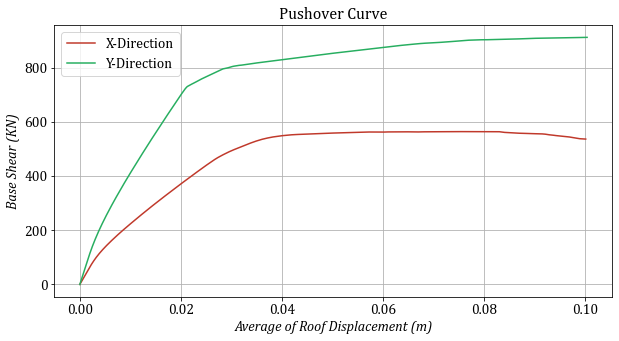

In [14]:
plt.figure(figsize=(10,5))

plt.plot(df_D_X['avg_D'], -df_R_X['sum_R'], color = '#C0392B', linewidth=1.5)
plt.plot(df_D_Y['avg_D'], -df_R_Y['sum_R'], color = '#27AE60', linewidth=1.5)


plt.ylabel('Base Shear (KN)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.xlabel('Average of Roof Displacement (m)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.grid(which='both')
plt.title('Pushover Curve',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
plt.yticks(fontname = 'Cambria', fontsize = 14)
plt.xticks(fontname = 'Cambria', fontsize = 14);
plt.legend(['X-Direction', 'Y-Direction'],prop={'family':'Cambria','size':14});

##### Ground Motion histroy

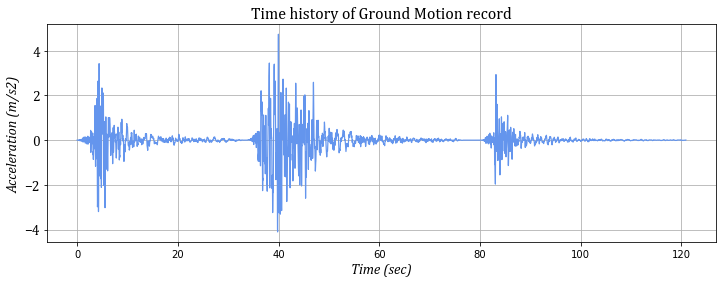

In [15]:
G_M =np.loadtxt('FGU_RC3DF_files/acc_1.txt')
times = np.arange(0,0.02*len(G_M),0.02)
plt.figure(figsize=(12,4))
plt.plot(times,G_M, color = '#6495ED', linewidth=1.2)
plt.ylabel('Acceleration (m/s2)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.xlabel('Time (sec)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.grid(which='both')
plt.title('Time history of Ground Motion record',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
plt.yticks(fontname = 'Cambria', fontsize = 14);

#### Time history of displacement and acceleration

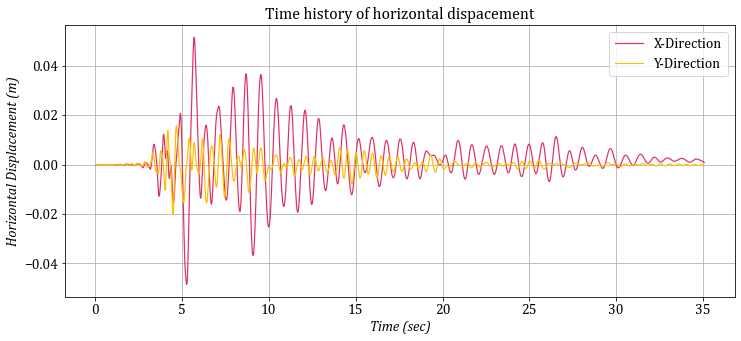

In [16]:
story_disp_X = np.loadtxt('FGU_RC3DF_files/TimeHistory_Story_DisplacementX1.1.out')
story_disp_Y = np.loadtxt('FGU_RC3DF_files/TimeHistory_Story_DisplacementY1.1.out')

plt.figure(figsize=(12,5))
plt.plot(story_disp_X[:,0], story_disp_X[:,1], color = '#DE3163', linewidth=1.2)
plt.plot(story_disp_Y[:,0], story_disp_Y[:,2], color = '#FFBF00', linewidth=1.2)
plt.ylabel('Horizontal Displacement (m)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.xlabel('Time (sec)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.grid(which='both')
plt.title('Time history of horizontal dispacement',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
plt.yticks(fontname = 'Cambria', fontsize = 14);
plt.xticks(fontname = 'Cambria', fontsize = 14);
plt.legend(['X-Direction', 'Y-Direction'], prop={'family':'Cambria','size':14});

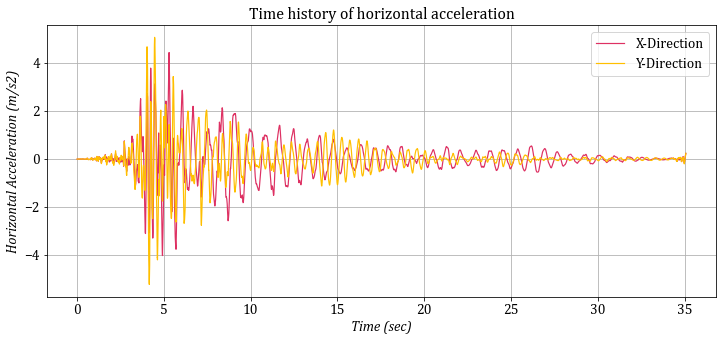

In [17]:
story_accel_X = np.loadtxt('FGU_RC3DF_files/TimeHistory_Story_AccelerationX1.1.out')
story_accel_Y = np.loadtxt('FGU_RC3DF_files/TimeHistory_Story_AccelerationY1.1.out')

plt.figure(figsize=(12,5))
plt.plot(story_accel_X[:,0], story_accel_X[:,1], color = '#DE3163', linewidth=1.2)
plt.plot(story_accel_Y[:,0], story_accel_Y[:,2], color = '#FFBF00', linewidth=1.2)
plt.ylabel('Horizontal Acceleration (m/s2)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.xlabel('Time (sec)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.grid(which='both')
plt.title('Time history of horizontal acceleration',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
plt.yticks(fontname = 'Cambria', fontsize = 14);
plt.xticks(fontname = 'Cambria', fontsize = 14);
plt.legend(['X-Direction', 'Y-Direction'], prop={'family':'Cambria','size':14});

### References

- <blockquote>Fernando Gutiérrez Urzúa's YouTube channel (https://www.youtube.com/user/lfgurzua) </blockquote>
- <blockquote>OpenseesPy Documentation (https://openseespydoc.readthedocs.io/en/latest/) </blockquote>
